# imports

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np
import os
from display_aux import *
from ships import SHIPS
from df_aux import *
from time_aux import *
from file_aux import *
from plot_aux import *
from parse_aux import *
import sys

In [2]:
ships = SHIPS()


In [3]:
%matplotlib ipympl

In [4]:
# Set display options to show all rows and params['params['params['params['params['params['params['params['columns']']']']']']']']
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


# Run definitions

In [5]:
params = {}
params['input_csv_file_name_full'] = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\Combined\\Spire_AIS_Combined_All_20231101_1106_000000000000.csv'
# params['input_csv_file_name_full'] = 'debug_data_base.csv'

params['columns_list_keep'] = None
params['filter_vessels_df_dic'] = {
        'max_time_diff[mins]':['<=',30]
        }
params['reload_level'] = 1
params['reload_df_filt'] = False
params['reload_vessels'] = True
params['save_folder_base'] = './pkl'

params['export_to_excel'] = False
params['ana_vessel_name'] = 'EYVAN'
params['ana_vessel_name'] = 'PENG FENG JI'

# params['df_filter_dic'] = {'position_timestamp':['<=','2023-11-01 02:00:00+0000']}
params['df_filter_dic'] = {}

# Load

In [6]:
save_folder = params['save_folder_base']+'/'+ get_file_base_name(params['input_csv_file_name_full'])
df = ships.load_raw_data(params['input_csv_file_name_full'],reload_level=params['reload_level'],save_folder=save_folder)

# filter_df
df = ships.prepare_df(df,reload_level=params['reload_level'],df_filter_dic=params['df_filter_dic'],save_folder=save_folder,columns_list_keep=params['columns_list_keep'])

# data_dic = ships.create_data_dic(df,reload_level=params['reload_level'],save_folder=save_folder)


load_row_data
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
filter_df
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
save df to ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_filt.pkl


In [7]:
display(df.time.min())
display(df.time.max())

Timestamp('2023-11-01 00:00:00+0000', tz='UTC')

Timestamp('2023-11-01 01:27:53+0000', tz='UTC')

In [8]:
# example
ship_data = ships.get_ship_df(df,'AOS VISION',item_type='name')
params = {'item_type': 'name'}
ship_data = ships.get_ship_df(df,'AOS VISION',**params)
data_stats = ships.get_ship_data_stats(ship_data)
info_df = ships.create_info_df(df, item_type='name',num_lines=1000,id_column_check=['mmsi'])





create item_dic
create info_df
processing name 0 out of 1000


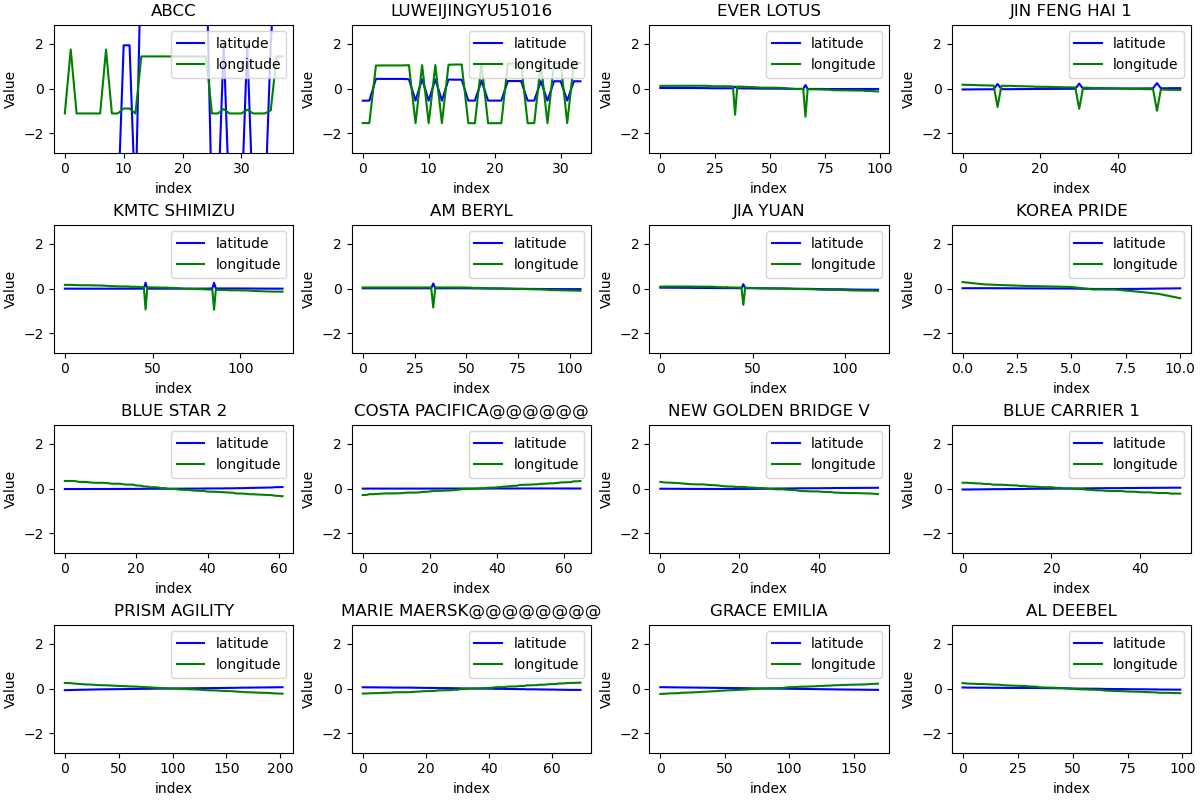

In [10]:
item_type = 'name'
control_item_type = 'mmsi'
info_df = info_df.sort_values('span_longitude',ascending=False)

info_df_filter = {'len': ['>',10],
                    f'num_{control_item_type}s':['==',1]}

info_df_filt = filter_df(info_df,info_df_filter)

ship_names = info_df_filt.index[range(16)].tolist()
ylim_val = [-info_df_filt['span_longitude'].max(),info_df_filt['span_longitude'].max()]
ships.plot_ship_data(df,ship_names,columns=['latitude', 'longitude'],ylim = ylim_val,pre_process='remove_bias')



In [11]:
# from scipy.signal import find_peaks


# ship_df = ships.get_ship_df(df,'AOS VISION',item_type='name')
# ship_df = normalize_columns(ship_df,columns=['latitude'],method='min-max')

# x = np.array(ship_df['latitude'])[1:]
# peak_points = find_peaks(x,distance=3)[0]
# plot (x,marker_points=peak_points,line_style='-',marker_style='*',marker_points_style='o')
